# Perform Data Preprocessing, QC, and cNMF for sample 1: 'WholeMes_SInt' 
Counts are data from 220314 <br>
h5ad and cNMF files are uploaded to: Shivdasani2022/220501_sample1-WholeMes_SInt/


## Environment Setup (220501)
Install software from pip, apt, and Github.  Load modules, configure workspace settings.

### Install Python Software

In [ ]:
!python --version

Python 3.7.13


In [ ]:
# As of May 2022, cNMF requires these specific versions of fastcluster and pyyaml
!pip install -q scanpy==1.8.2 leidenalg==0.8.10 scrublet==0.2.3 wget==3.2 
!pip install -q pyyaml==5.3.1 fastcluster==1.1.26 cnmf==1.3.2

     |████████████████████████████████| 2.0 MB 5.2 MB/s 
     |████████████████████████████████| 1.3 MB 38.6 MB/s 
     |████████████████████████████████| 96 kB 4.3 MB/s 
     |████████████████████████████████| 88 kB 4.5 MB/s 
     |████████████████████████████████| 3.1 MB 20.7 MB/s 
     |████████████████████████████████| 646 kB 66.0 MB/s 
     |████████████████████████████████| 1.1 MB 41.9 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 269 kB 5.0 MB/s 
     |████████████████████████████████| 155 kB 54.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
# We use lftp to upload results files to our lab Box server
!sudo apt-get install -qq lftp

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package netbase.
(Reading database ... 155203 files and directories currently installed.)
Preparing to unpack .../archives/netbase_5.4_all.deb ...
Unpacking netbase (5.4) ...
Selecting previously unselected package lftp.
Preparing to unpack .../lftp_4.8.1-1ubuntu0.2_amd64.deb ...
Unpacking lftp (4.8.1-1ubuntu0.2) ...
Setting up netbase (5.4) ...
Setting up lftp (4.8.1-1ubuntu0.2) ...
Processing triggers for mime-support (3.60ubuntu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for

Kernal restart can be invoked, if necessary, to reload current package versions.

In [ ]:
# Restart Runtime 
#import os
#os.kill(os.getpid(), 9)

### Load Python packages and configure some global settings


In [ ]:
# Import Python packages
import os, sys, wget, pickle
import scrublet as scr
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
from cnmf import cNMF

# Don't limit pandas column #
pd.options.display.max_columns=None

Install packages from Github

In [ ]:
# Clone our own custom Python functions from Github 
if not os.path.exists('scTools-py'): 
    !git clone https://github.com/wagnerde/scTools-py.git
sys.path.append('scTools-py/')
import scTools_dew as dew

Cloning into 'scTools-py'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 209 (delta 60), reused 63 (delta 59), pack-reused 143
Receiving objects: 100% (209/209), 63.17 KiB | 4.21 MiB/s, done.
Resolving deltas: 100% (123/123), done.


## Preprocessing

#### Download raw files and import into AnnData

In [ ]:
!mkdir -p /content/Shiv2022Counts/WholeMes_SInt/
!wget https://ucsf.box.com/shared/static/d54h0cv4lwajsd8y0hfvfzaut4t1egos.txt -O /content/Shiv2022Counts/WholeMes_SInt/WholeMes_SInt_counts.txt

--2022-05-04 21:49:45--  https://ucsf.box.com/shared/static/d54h0cv4lwajsd8y0hfvfzaut4t1egos.txt
Resolving ucsf.box.com (ucsf.box.com)... 107.152.26.197
Connecting to ucsf.box.com (ucsf.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/d54h0cv4lwajsd8y0hfvfzaut4t1egos.txt [following]
--2022-05-04 21:49:46--  https://ucsf.box.com/public/static/d54h0cv4lwajsd8y0hfvfzaut4t1egos.txt
Reusing existing connection to ucsf.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ucsf.app.box.com/public/static/d54h0cv4lwajsd8y0hfvfzaut4t1egos.txt [following]
--2022-05-04 21:49:46--  https://ucsf.app.box.com/public/static/d54h0cv4lwajsd8y0hfvfzaut4t1egos.txt
Resolving ucsf.app.box.com (ucsf.app.box.com)... 107.152.26.201
Connecting to ucsf.app.box.com (ucsf.app.box.com)|107.152.26.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl2.boxcloud

In [ ]:
# Load library into ScanPy
Shiv2022_WholeMes_SInt = sc.read_text('/content/Shiv2022Counts/WholeMes_SInt/WholeMes_SInt_counts.txt').transpose()
Shiv2022_WholeMes_SInt

AnnData object with n_obs × n_vars = 2042 × 15640

#### Cell Barcode Abundance Filtering

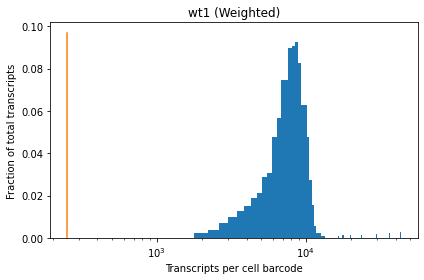

Filtering barcodes for wt1  ( 2042 / 2042 )


AnnData object with n_obs × n_vars = 2042 × 15640
    obs: 'n_counts', 'n_genes'

In [ ]:
# Apparently barcode filtering has already been performed.  At least for now we won't trim any further.
dew.filter_abundant_barcodes(Shiv2022_WholeMes_SInt, filter_cells=True, logscale=False, threshold=250, library_name='wt1')

In [ ]:
# Based on the above distribution, place a manual threshold
#dew.filter_abundant_barcodes(Shiv2022_WholeMes_SInt, filter_cells=False, logscale=False, threshold=1000, library_name='wt1')

#### Cell Doublet Filtering

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 33.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.7%
Elapsed time: 4.2 seconds
Doublet-like Cells = 5


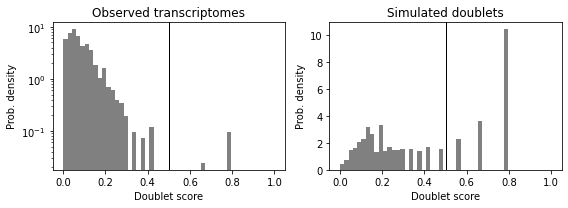

In [ ]:
# Identify and putative doublets and plot doublet scores
np.random.seed(802) # set random seed for reproducibility
scrub = scr.Scrublet(Shiv2022_WholeMes_SInt.X, expected_doublet_rate=0.1)
Shiv2022_WholeMes_SInt.obs['doublet_scores'], Shiv2022_WholeMes_SInt.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram();
print("Doublet-like Cells = {:d}" .format(sum(Shiv2022_WholeMes_SInt.obs['predicted_doublets'])))

Detected doublet rate = 5.4%
Estimated detectable doublet fraction = 61.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.8%
Doublet-like Cells = 110


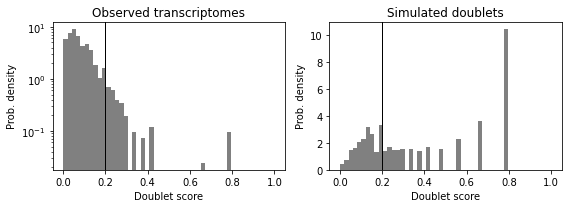

In [ ]:
# Adjust doublet score threshold 
Shiv2022_WholeMes_SInt.obs['predicted_doublets'] = scrub.call_doublets(threshold=0.2)
fg,ax = scrub.plot_histogram();
print("Doublet-like Cells = {:d}" .format(sum(Shiv2022_WholeMes_SInt.obs['predicted_doublets'])))
fg.savefig('./scrublet_Shiv2022_WholeMes_SInt_hist.png', bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


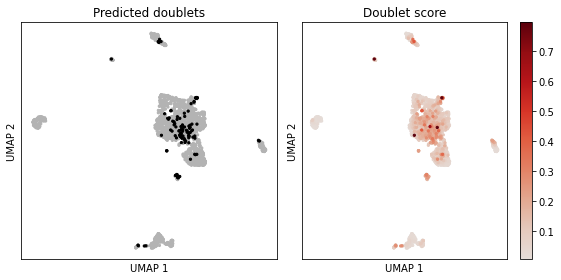

In [ ]:
# Overlay doublet scores on a quick UMAP embedding 
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, n_neighbors=20, min_dist=0.2))
fg,ax = scrub.plot_embedding('UMAP', order_points=True);
fg.savefig('./scrublet_Shiv2022_WholeMes_SInt_umap.png', bbox_inches='tight')

In [ ]:
# Remove doublets from the AnnData object 
print("Total Cells = {:d}" .format(len(Shiv2022_WholeMes_SInt)))
print("Doublet-like Cells = {:d}" .format(sum(Shiv2022_WholeMes_SInt.obs['predicted_doublets'])))
print("Non-Doublet Cells = {:d}" .format(len(Shiv2022_WholeMes_SInt) - sum(Shiv2022_WholeMes_SInt.obs['predicted_doublets'])))
Shiv2022_WholeMes_SInt = Shiv2022_WholeMes_SInt[~Shiv2022_WholeMes_SInt.obs['predicted_doublets'],:]
Shiv2022_WholeMes_SInt

Total Cells = 2042
Doublet-like Cells = 110
Non-Doublet Cells = 1932


View of AnnData object with n_obs × n_vars = 1932 × 15640
    obs: 'n_counts', 'n_genes', 'doublet_scores', 'predicted_doublets'

#### Mito Filtering

In [ ]:
# annotate the group of mitochondrial genes as 'mt'
Shiv2022_WholeMes_SInt.var['mt'] = Shiv2022_WholeMes_SInt.var_names.str.startswith('mt-')  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  


In [ ]:
# calculate cell metrics
sc.pp.calculate_qc_metrics(Shiv2022_WholeMes_SInt, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

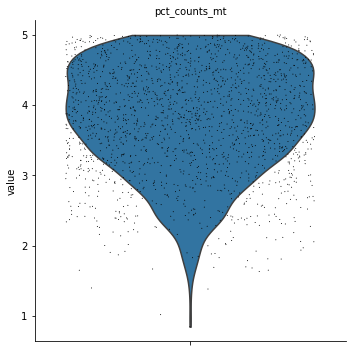

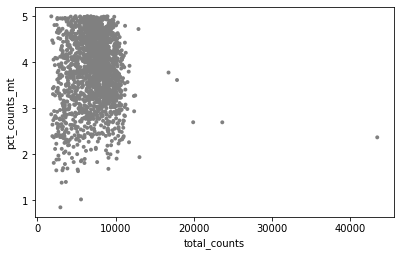

In [ ]:
# explore the distribution of high mt count cells
sc.pl.violin(Shiv2022_WholeMes_SInt, ['pct_counts_mt'], jitter=0.4, ylabel=' ', multi_panel=True)
sc.pl.scatter(Shiv2022_WholeMes_SInt, x='total_counts', y='pct_counts_mt')

In [ ]:
# Looks like the mito fraction has already been trimmed.  At least for now we won't trim any further.
#Shiv2022_WholeMes_SInt = Shiv2022_WholeMes_SInt[Shiv2022_WholeMes_SInt.obs.pct_counts_mt < 6, :]
Shiv2022_WholeMes_SInt

AnnData object with n_obs × n_vars = 1932 × 15640
    obs: 'n_counts', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

#### Save to h5ad

In [ ]:
Shiv2022_WholeMes_SInt.raw = Shiv2022_WholeMes_SInt.copy()
Shiv2022_WholeMes_SInt.X = Shiv2022_WholeMes_SInt.X.astype(np.float64) # float64 datatype required for compatibility with cNMF!
Shiv2022_WholeMes_SInt.write('Shiv2022_WholeMes_SInt_raw.220501.h5ad')

## Perform cNMF

In [ ]:
# cNMF settings (modify as needed)
cNMF_n_iter = 100 
cNMF_n_var_genes = 2000 
cNMF_output_dir = './cNMF-output'
cNMF_run_name = 'Shiv2022-cNMF'
cNMF_k_range = [12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
cNMF_rand_seed = 14 
cNMF_input_data = 'Shiv2022_WholeMes_SInt_raw.220501.h5ad' 

[Worker 0]. Starting task 0.
[Worker 0]. Starting task 1.
[Worker 0]. Starting task 2.
[Worker 0]. Starting task 3.
[Worker 0]. Starting task 4.
[Worker 0]. Starting task 5.
[Worker 0]. Starting task 6.
[Worker 0]. Starting task 7.
[Worker 0]. Starting task 8.
[Worker 0]. Starting task 9.
[Worker 0]. Starting task 10.
[Worker 0]. Starting task 11.
[Worker 0]. Starting task 12.
[Worker 0]. Starting task 13.
[Worker 0]. Starting task 14.
[Worker 0]. Starting task 15.
[Worker 0]. Starting task 16.
[Worker 0]. Starting task 17.
[Worker 0]. Starting task 18.
[Worker 0]. Starting task 19.
[Worker 0]. Starting task 20.
[Worker 0]. Starting task 21.
[Worker 0]. Starting task 22.
[Worker 0]. Starting task 23.
[Worker 0]. Starting task 24.
[Worker 0]. Starting task 25.
[Worker 0]. Starting task 26.
[Worker 0]. Starting task 27.
[Worker 0]. Starting task 28.
[Worker 0]. Starting task 29.
[Worker 0]. Starting task 30.
[Worker 0]. Starting task 31.
[Worker 0]. Starting task 32.
[Worker 0]. Starting

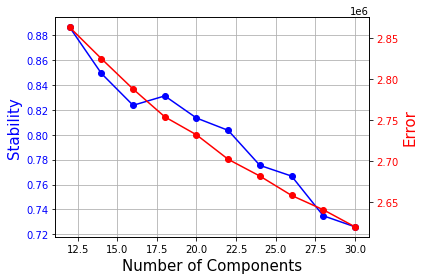

In [ ]:
# Run the Prepare, Factorize, and Combine commands
cnmf_obj = cNMF(output_dir=cNMF_output_dir, name=cNMF_run_name)

# ask cNMF to detect variable genes internally
#cnmf_obj.prepare(counts_fn=cNMF_input_data, num_highvar_genes=cNMF_n_var_genes, components=cNMF_k_range, n_iter=cNMF_n_iter, seed=cNMF_rand_seed)
# use a pre-built list of variable genes
cnmf_obj.prepare(counts_fn=cNMF_input_data, components=cNMF_k_range, n_iter=cNMF_n_iter, seed=cNMF_rand_seed)

cnmf_obj.factorize(worker_i=0, total_workers=1)
cnmf_obj.combine()
cnmf_obj.k_selection_plot()

/usr/local/lib/python3.7/dist-packages/cnmf/cnmf.py:702: RuntimeWarning: invalid value encountered in true_divide
  norm_tpm = (tpm.X - tpm_stats['__mean'].values) / tpm_stats['__std'].values


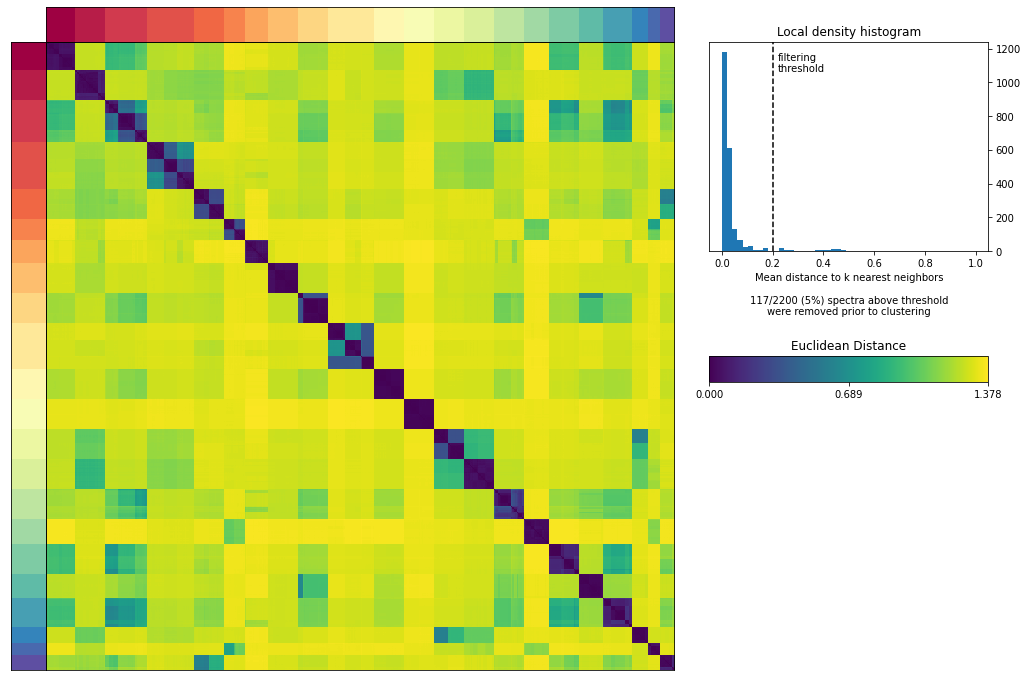

In [ ]:
# Choose consensus parameters (modify as needed)
cNMF_k = 22
cNMF_density_thresh = 0.2
cNMF_local_neighborhood_size = 0.3

# Run Consensus 
cnmf_obj.consensus(k=cNMF_k, density_threshold=cNMF_density_thresh, local_neighborhood_size=cNMF_local_neighborhood_size)

## Upload Results to BOX

In [ ]:
# Create a folder containing the h5ad and cNMF results
!mkdir -p upload_to_Box
!cp -r /content/Shiv2022_WholeMes_SInt_raw.220501.h5ad /content/upload_to_Box/ 
!tar -czf /content/upload_to_Box/Shiv2022_WholeMes_SInt_raw.220501.cNMF.tar.gz /content/cNMF-output/

In [ ]:
# Prepare LFTP shell command
local_dir = '/content/upload_to_Box/'
remote_box_dir = '/Box_Home/WAGNER_LAB_SHARED/Dan_Wagner/ANALYSES/Shivdasani2022/220501_sample1-WholeMes_SInt/'
box_username = 'XXX,XXX' 

lftp_cmd = 'lftp -e "mirror -R %s %s; bye" -u %s ftps://ftp.box.com' % (local_dir, remote_box_dir, box_username)

# Execute shell command
print('Executing:\n %s' % (lftp_cmd))
! {lftp_cmd}